In [1]:
import wandb

wandb.login()

wandb: Currently logged in as: steliobompai (synthetic-data-gan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Point Forecasting

# Wandb artifacts for DL models (no TFT)

In [2]:
# ==== PROJECT ====
WANDB_ENTITY  = "synthetic-data-gan"
WANDB_PROJECT = "HALCOR-ENERGY-TIMESERIES-FORECASTING-MSE-TESTING"  # <-- point forecasting project

# ==== FILTERS ====
FILTERS = {
    "config.testing_stage": True,   # only test-stage runs
    "config.model_name":     None,  # e.g., {"LSTM","BiLSTM","TFT"}
    "config.scaler_name":    None,  # e.g., {"standard","min-max"}
    "config.batch_size":     None,  # e.g., {16,32}
    "config.data_augmentation": None,
    "config.pinball_loss_usage": None,
    "config.fake_data_len":  None,  # e.g., {200,400,800,1200,1600}
}

# ==== ARTIFACT KEYS ====
ARTIFACT_TYPE = "predictions"
PREFERRED_KEYS = ("y_pred", "y_true")                # preferred
LEGACY_KEYS    = ("predictions", "ground_truth")     # your historic artifacts

In [3]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Any
from collections import defaultdict


# ---------- small utilities ----------
def _get_first(d: dict, *names, default=None):
    for n in names:
        if n in d and d[n] is not None:
            return d[n]
    return default

def _cfg_get(cfg: dict, meta: dict, *alts, default=None):
    val = _get_first(cfg, *alts)
    if val is None:
        val = _get_first(meta, *alts, default=default)
    return val

def _matches(value: Any, wanted: Any) -> bool:
    if wanted is None:
        return True
    if isinstance(wanted, (list, tuple, set)):
        return value in wanted
    return value == wanted



# ---------- loader ----------
def load_npz_first(path_dir: str) -> dict:
    cands = sorted(glob.glob(os.path.join(path_dir, "*.npz")))
    if not cands:
        raise FileNotFoundError(f"No .npz files in {path_dir}")
    arr = np.load(cands[0], allow_pickle=True)
    keys = arr.files

    if all(k in keys for k in PREFERRED_KEYS):
        y_pred, y_true = arr[PREFERRED_KEYS[0]], arr[PREFERRED_KEYS[1]]
    elif all(k in keys for k in LEGACY_KEYS):
        y_pred, y_true = arr[LEGACY_KEYS[0]], arr[LEGACY_KEYS[1]]
    else:
        raise KeyError(f"Expected keys {PREFERRED_KEYS} or {LEGACY_KEYS} not found. Keys: {list(keys)}")

    timestamps = arr["timestamps"] if "timestamps" in keys else None
    horizons   = arr["horizons"]   if "horizons"   in keys else None
    return dict(y_pred=y_pred, y_true=y_true, timestamps=timestamps, horizons=horizons)



# ---------- shapes & filters ----------
def ensure_shapes(y_true: np.ndarray, y_pred_list: List[np.ndarray]):
    y_true = np.asarray(y_true)
    if y_true.ndim == 1:
        y_true = y_true[:, None]
    YH = y_true.shape

    fixed = []
    for p in y_pred_list:
        p = np.asarray(p)
        if p.ndim == 1:
            p = p[:, None]
        if p.shape != YH:
            raise ValueError(f"Prediction shape {p.shape} != y_true shape {YH}")
        fixed.append(p)
    return y_true, fixed

def run_matches_filters(run, filters: dict) -> bool:
    for k, want in filters.items():
        if want is None:
            continue
        if not k.startswith("config."):
            return False
        cfg_key = k.split(".", 1)[1]
        val = run.config.get(cfg_key)
        if not _matches(val, want):
            return False
    return True



# ---------- bias-variance ----------
def bias_variance_from_seeds(y_true: np.ndarray, preds_seeds: np.ndarray) -> dict:
    # y_true (T,H), preds_seeds (S,T,H)
    P_mean = preds_seeds.mean(axis=0)                           # (T,H)
    bias2_h = ((P_mean - y_true) ** 2).mean(axis=0)             # (H,)
    ddof = 1 if preds_seeds.shape[0] > 1 else 0
    var_h = preds_seeds.var(axis=0, ddof=ddof).mean(axis=0)     # (H,)
    mse_h = ((preds_seeds - y_true) ** 2).mean(axis=(0, 1))     # (H,)
    noise_h = np.clip(mse_h - (bias2_h + var_h), 0, None)

    return {
        "bias2_h": bias2_h, "var_h": var_h, "noise_h": noise_h, "mse_h": mse_h,
        "bias2": bias2_h.mean(), "var": var_h.mean(),
        "noise": noise_h.mean(), "mse": mse_h.mean(),
    }



# # --- plotting ---

# def plot_before_after(stats_real: dict, stats_aug: dict, title: str):
#     labels = ["Bias²", "Variance", "Noise", "Total MSE"]
#     real_vals = [stats_real["bias2"], stats_real["var"], stats_real["noise"], stats_real["mse"]]
#     aug_vals  = [stats_aug["bias2"],  stats_aug["var"],  stats_aug["noise"],  stats_aug["mse"]]

#     x = np.arange(len(labels))
#     width = 0.38
#     plt.figure(figsize=(8,5))
#     plt.bar(x - width/2, real_vals, width, label="Real")
#     plt.bar(x + width/2, aug_vals,  width, label="Augmented")
#     plt.xticks(x, labels)
#     plt.ylabel("Error")
#     plt.title(title)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


# def plot_deltas(stats_real: dict, stats_aug: dict, title: str):
#     labels = ["Bias²", "Variance", "Noise", "Total MSE"]
#     deltas = [
#         stats_aug["bias2"] - stats_real["bias2"],
#         stats_aug["var"]   - stats_real["var"],
#         stats_aug["noise"] - stats_real["noise"],
#         stats_aug["mse"]   - stats_real["mse"],
#     ]
#     x = np.arange(len(labels))
#     plt.figure(figsize=(8,5))
#     plt.bar(x, deltas)
#     plt.axhline(0, linewidth=1)
#     plt.xticks(x, labels)
#     plt.ylabel("Aug - Real")
#     plt.title(title + " (Δ)")
#     plt.tight_layout()
#     plt.show()


In [4]:
from collections import defaultdict

# ---------- build with diagnostics ----------
def build_configs_debug(entity: str,
                        project: str,
                        filters: dict,
                        latest_only: bool = True,
                        show_examples: int = 20):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")

    dbg = {
        "total_runs_scanned": len(runs),
        "runs_passed_filters": 0,
        "runs_missing_artifact": 0,
        "runs_loaded_artifacts": 0,
        "artifact_versions_downloaded": 0,
        "runs_errors_loading": 0,
        "skipped_by_filters": [],
        "missing_artifact": [],
        "errors_loading": [],
    }

    configs = {}
    print(f"[build_configs_debug] Scanning {len(runs)} runs…")

    def _record_filtered(r): dbg["skipped_by_filters"].append((r.id, r.name))
    def _record_missing(r): 
        dbg["runs_missing_artifact"] += 1
        dbg["missing_artifact"].append((r.id, r.name))
    def _record_error(r, e):
        dbg["runs_errors_loading"] += 1
        dbg["errors_loading"].append((r.id, r.name, str(e)))

    for r in runs:
        if not run_matches_filters(r, filters):
            _record_filtered(r); continue
        dbg["runs_passed_filters"] += 1

        arts = [a for a in r.logged_artifacts() if a.type == ARTIFACT_TYPE]
        if not arts:
            _record_missing(r); continue

        arts_to_process = [sorted(arts, key=lambda a: a.created_at)[-1]] if latest_only else sorted(arts, key=lambda a: a.created_at)

        for art in arts_to_process:
            try:
                local_dir = art.download()
                arrays = load_npz_first(local_dir)
                dbg["artifact_versions_downloaded"] += 1

                meta = dict(art.metadata or {})
                cfg  = dict(r.config or {})

                model        = _cfg_get(cfg, meta, "model_name", "model")
                scaler       = _cfg_get(cfg, meta, "scaler_name", "scaler")
                batch_size   = _cfg_get(cfg, meta, "batch_size")
                data_aug     = _cfg_get(cfg, meta, "data_augmentation", "data_aug")
                pinball_used = _cfg_get(cfg, meta, "pinball_loss_usage", "pinball_used")
                fake_len     = _cfg_get(cfg, meta, "fake_data_len")
                seed         = _cfg_get(cfg, meta, "seed")

                if not _matches(fake_len, filters.get("config.fake_data_len")):
                    continue

                key = (model, scaler, batch_size, data_aug, pinball_used, fake_len)
                entry = configs.setdefault(key, {
                    "y_true": None, "preds": [], "seeds": [],
                    "meta": {
                        "model": model, "scaler": scaler, "batch_size": batch_size,
                        "data_aug": data_aug, "pinball_used": pinball_used,
                        "fake_data_len": fake_len
                    }
                })

                if entry["y_true"] is None:
                    entry["y_true"] = arrays["y_true"]
                    entry["_timestamps"] = arrays.get("timestamps", None)
                    entry["_horizons"]   = arrays.get("horizons",   None)

                entry["preds"].append(arrays["y_pred"])
                entry["seeds"].append(seed)
                dbg["runs_loaded_artifacts"] += 1

            except Exception as e:
                _record_error(r, e); continue

    # finalize
    for key, entry in configs.items():
        y_true, preds_list = ensure_shapes(entry["y_true"], entry["preds"])
        entry["y_true"] = y_true
        entry["preds"]  = np.stack(preds_list)  # (S,T,H)

    # summary
    print("\n==== Diagnostics Summary ====")
    for k in ("total_runs_scanned","runs_passed_filters","runs_loaded_artifacts",
              "runs_missing_artifact","artifact_versions_downloaded","runs_errors_loading"):
        print(f"{k.replace('_',' ').title()}: {dbg[k]}")
    return configs, dbg

configs, dbg = build_configs_debug(WANDB_ENTITY, WANDB_PROJECT, FILTERS, latest_only=True)
print(f"\nBuilt {len(configs)} configuration groups.")



[build_configs_debug] Scanning 146 runs…


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo


==== Diagnostics Summary ====
Total Runs Scanned: 146
Runs Passed Filters: 121
Runs Loaded Artifacts: 121
Runs Missing Artifact: 0
Artifact Versions Downloaded: 121
Runs Errors Loading: 0

Built 25 configuration groups.


In [5]:
configs.keys()

dict_keys([('BiLSTM', 'standard', 32, False, False, 0), ('BiLSTM', 'standard', 16, False, False, 0), ('LSTM', 'standard', 16, False, False, 0), ('LSTM', 'min-max', 16, False, False, 0), ('XGBoost', 'standard', 0, False, False, None), ('BiLSTM', 'standard', 32, True, False, 200), ('BiLSTM', 'standard', 32, True, False, 400), ('BiLSTM', 'standard', 32, True, False, 800), ('BiLSTM', 'standard', 32, True, False, 1200), ('BiLSTM', 'standard', 32, True, False, 1600), ('BiLSTM', 'standard', 16, True, False, 1600), ('BiLSTM', 'standard', 16, True, False, 200), ('BiLSTM', 'standard', 16, True, False, 400), ('BiLSTM', 'standard', 16, True, False, 800), ('BiLSTM', 'standard', 16, True, False, 1200), ('LSTM', 'standard', 16, True, False, 200), ('LSTM', 'min-max', 16, True, False, 200), ('LSTM', 'standard', 16, True, False, 400), ('LSTM', 'min-max', 16, True, False, 400), ('LSTM', 'standard', 16, True, False, 800), ('LSTM', 'min-max', 16, True, False, 800), ('LSTM', 'standard', 16, True, False, 120

In [6]:
configs

{('BiLSTM',
  'standard',
  32,
  False,
  False,
  0): {'y_true': array([[156.173 ],
         [172.669 ],
         [122.129 ],
         [156.684 ],
         [190.953 ],
         [174.099 ],
         [ 83.323 ],
         [ 54.43  ],
         [ 84.142 ],
         [102.605 ],
         [132.917 ],
         [110.556 ],
         [ 67.764 ],
         [120.14  ],
         [138.857 ],
         [113.043 ],
         [114.05  ],
         [118.991 ],
         [126.389 ],
         [126.091 ],
         [118.363 ],
         [145.23  ],
         [104.759 ],
         [ 70.4   ],
         [111.28  ],
         [125.208 ],
         [114.077 ],
         [141.462 ],
         [134.284 ],
         [126.344 ],
         [122.916 ],
         [109.805 ],
         [129.5815],
         [158.3905],
         [123.45  ],
         [104.285 ],
         [118.874 ],
         [135.45  ],
         [106.45  ],
         [ 62.667 ],
         [117.835 ],
         [119.965 ],
         [114.129 ],
         [116.278 ],
         [1

In [7]:
# configs, debug_info = build_configs_debug(
#     entity=WANDB_ENTITY,
#     project=WANDB_PROJECT,
#     filters=FILTERS,
#     latest_only=True,      # set False to download all versions per run
#     show_examples=50
# )

# print(f"\nBuilt {len(configs)} configuration groups.")

# Load the TFT .npz files

In [8]:
import os
import re
import numpy as np

folder_path = "artifacts/TFT Predictions/Point Forecasting"

npz_files = [f for f in os.listdir(folder_path) if f.endswith(".npz")]

# TFT_<seed>_testing<...>_pinball<True|False>_aug<True|False>_fake_data_length<fake_len>*.npz
pattern = re.compile(
    r"(?P<model>[^_]+)_"                 # model name (TFT)
    r"(?P<seed>\d+)_"                    # seed (42)
    r"testing(?P<testing>\w+)_"          # testingTrue/False (ignored)
    r"pinball(?P<pinball>\w+)_"          # pinballTrue/False
    r"aug(?P<data_aug>\w+)_"             # augTrue/False
    r"fake_data_length(?P<fake_len>\d+)" # fake length
)

def _norm_vec(a):
    a = np.asarray(a)
    if a.ndim == 1:
        a = a[:, None]      # (T,) -> (T,1)
    return a

for file in npz_files:
    m = pattern.match(file)
    if not m:
        print(f"⚠️ Could not parse: {file}")
        continue

    gd = m.groupdict()
    model    = gd["model"]                 # "TFT"
    seed     = int(gd["seed"])
    batch    = 16                          # fixed for TFT
    scaler   = "standard"                  # fixed
    pinball  = (gd["pinball"] == "True")
    data_aug = (gd["data_aug"] == "True")
    fake_len = int(gd["fake_len"])

    # load + normalize shapes
    file_path = os.path.join(folder_path, file)
    npz = np.load(file_path)
    y_true = _norm_vec(npz["ground_truth"])
    preds  = _norm_vec(npz["predictions"])   # (T,1)

    key = (model, scaler, batch, data_aug, pinball, fake_len)

    entry = configs.setdefault(key, {
        "y_true": None,
        "preds": None,          # will become ndarray (S,T,1)
        "seeds": [],
        "_seen_seeds": set(),   # internal helper for de-dupe
    })

    # set y_true once per key (optional consistency check)
    if entry["y_true"] is None:
        entry["y_true"] = y_true
    # else: you could assert equality or skip if mismatched

    # append preds as a new seed slice
    if entry["preds"] is None:
        entry["preds"] = preds[None, ...]        # (1,T,1)
    else:
        entry["preds"] = np.concatenate([entry["preds"], preds[None, ...]], axis=0)  # (S+1,T,1)

    entry["seeds"].append(seed)
    entry["_seen_seeds"].add(seed)

# clean internal helper
for v in configs.values():
    v.pop("_seen_seeds", None)

print(f"Total configs now: {len(configs)}")


Total configs now: 31


Computed stats for 31 configurations.
Base configs: 6 | Paired: 5 | Real-only: 1 | Aug-only: 0
Paired base configs ready: 5


<>:148: SyntaxWarning: invalid escape sequence '\%'
<>:155: SyntaxWarning: invalid escape sequence '\%'
<>:162: SyntaxWarning: invalid escape sequence '\%'
<>:169: SyntaxWarning: invalid escape sequence '\%'
<>:175: SyntaxWarning: invalid escape sequence '\%'
<>:182: SyntaxWarning: invalid escape sequence '\%'
<>:186: SyntaxWarning: invalid escape sequence '\%'
<>:148: SyntaxWarning: invalid escape sequence '\%'
<>:155: SyntaxWarning: invalid escape sequence '\%'
<>:162: SyntaxWarning: invalid escape sequence '\%'
<>:169: SyntaxWarning: invalid escape sequence '\%'
<>:175: SyntaxWarning: invalid escape sequence '\%'
<>:182: SyntaxWarning: invalid escape sequence '\%'
<>:186: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_47449/3041770990.py:148: SyntaxWarning: invalid escape sequence '\%'
  bias_row = {"Metric": "Bias$^2$ (Δ\%)"}
/tmp/ipykernel_47449/3041770990.py:155: SyntaxWarning: invalid escape sequence '\%'
  bias_row["Best (Δ\%)"] = f"\\textbf{{{bias_delta[1+best_b_id

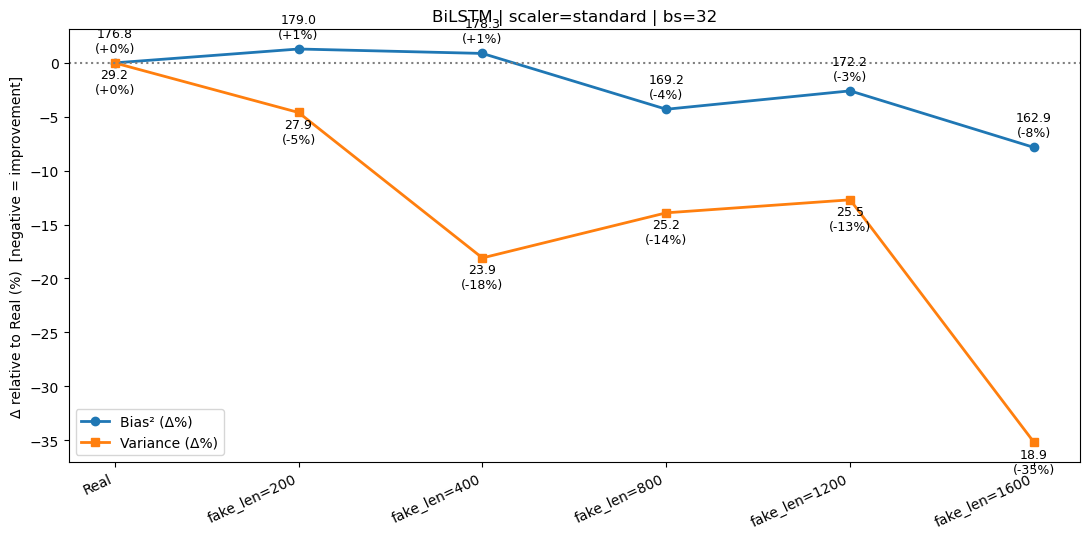

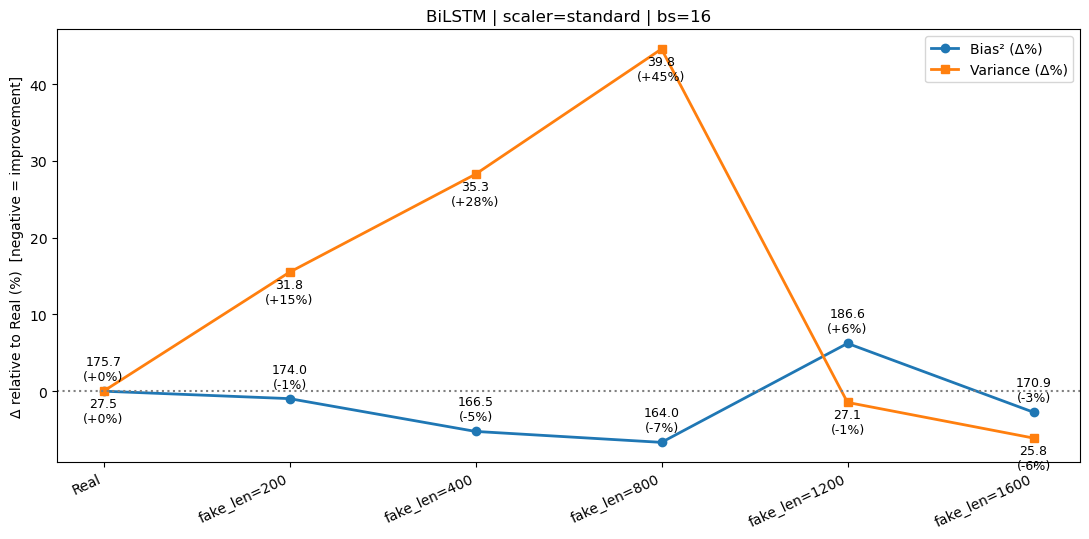

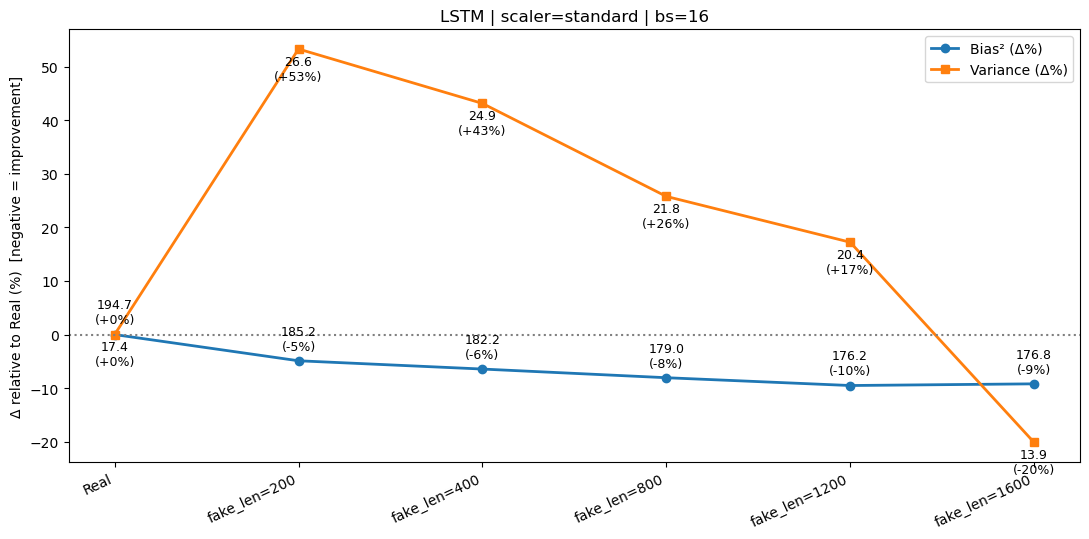

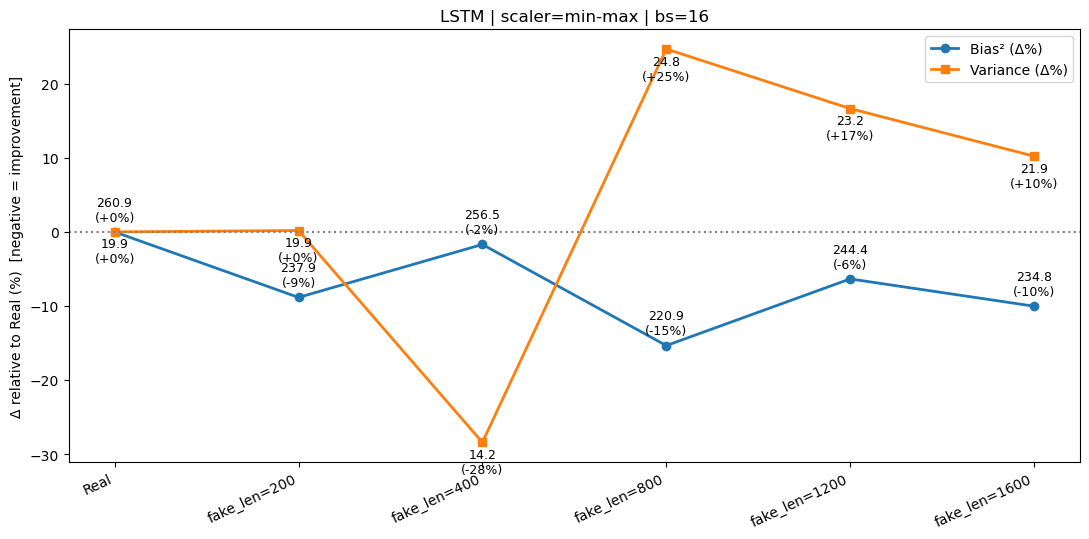

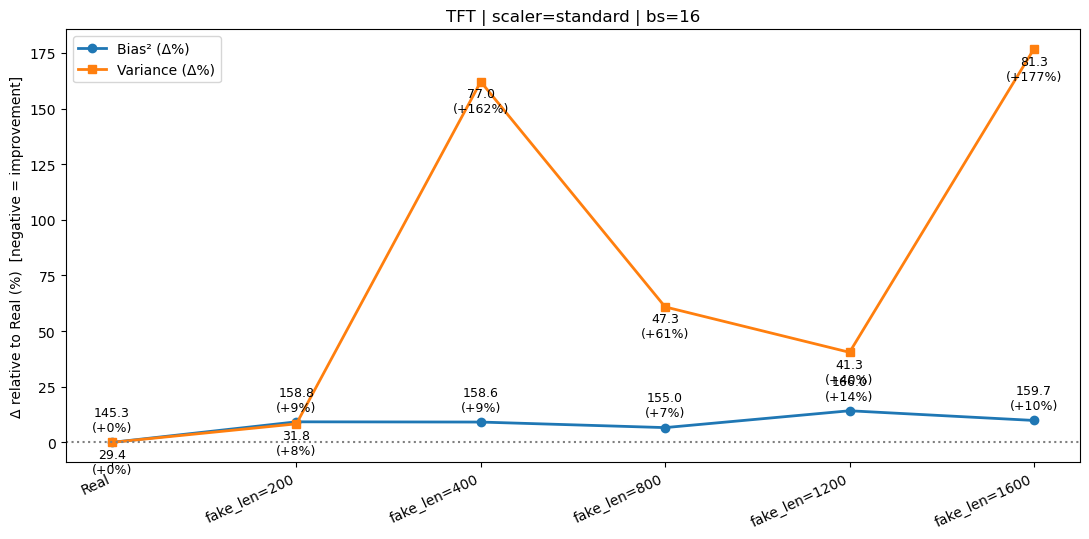

In [9]:
# --- 1) compute stats per configuration (unchanged) ---

# ---------- stats ----------
def compute_stats_per_config(configs: dict) -> Dict[Tuple, dict]:
    return {k: bias_variance_from_seeds(v["y_true"], v["preds"]) for k, v in configs.items()}

stats = compute_stats_per_config(configs)
print(f"Computed stats for {len(stats)} configurations.")


# --- 2) group real vs each augmented fake_data_len for fair comparisons ---

from collections import defaultdict

# ---------- coverage + grouping ----------
def summarize_coverage(stats: dict):
    cov = defaultdict(lambda: {"has_real": False, "fake_lens": set()})
    for key in stats.keys():
        model, scaler, batch, data_aug, pinball, fake_len = key if len(key)==6 else (*key, None)
        base = (model, scaler, batch, pinball)
        if data_aug in (False, 0, "False", "false", None):
            cov[base]["has_real"] = True
        else:
            cov[base]["fake_lens"].add(fake_len)
    total = len(cov)
    paired = sum(1 for v in cov.values() if v["has_real"] and v["fake_lens"])
    only_real = sum(1 for v in cov.values() if v["has_real"] and not v["fake_lens"])
    only_aug  = sum(1 for v in cov.values() if (not v["has_real"]) and v["fake_lens"])
    print(f"Base configs: {total} | Paired: {paired} | Real-only: {only_real} | Aug-only: {only_aug}")
    return cov

coverage = summarize_coverage(stats)

def group_for_comparison(stats: dict):
    comps = defaultdict(lambda: {"real": None, "aug": {}})
    for key, s in stats.items():
        model, scaler, batch, data_aug, pinball, fake_len = key if len(key)==6 else (*key, None)
        base_key = (model, scaler, batch, pinball)
        if data_aug in (False, 0, "False", "false", None):
            comps[base_key]["real"] = s
        else:
            comps[base_key]["aug"][fake_len] = s
    # keep only paired
    return {k:v for k,v in comps.items() if v["real"] is not None and v["aug"]}

comps = group_for_comparison(stats)
print(f"Paired base configs ready: {len(comps)}")


import numpy as np
import matplotlib.pyplot as plt

# ---------- plotting (percent vs REAL, annotated) ----------
def _sort_key_len(k):
    try: return (0, float(k))
    except: return (1, str(k))

def _label_for(k): return "Real" if k == "__REAL__" else f"fake_len={k}"

def plot_bias_var_delta(comps: dict, annotate: bool = True, round_vals: int = 1):
    """
    Plots Bias² and Variance as Δ% relative to the Real baseline (Real=0%).
    Negative Δ% means improvement (lower than Real).
    """
    for (model, scaler, batch, pinball), bundle in comps.items():
        real_stats = bundle["real"]; aug_map = bundle["aug"]
        keys = ["__REAL__"] + [k for k,_ in sorted(aug_map.items(), key=lambda kv: _sort_key_len(kv[0]))]
        labels = [_label_for(k) for k in keys]

        bias_abs, var_abs = [], []
        for k in keys:
            s = real_stats if k=="__REAL__" else aug_map[k]
            bias_abs.append(float(s["bias2"]))
            var_abs.append(float(s["var"]))
        bias_abs, var_abs = np.array(bias_abs), np.array(var_abs)

        # % vs REAL
        b0 = bias_abs[0] if bias_abs[0] != 0 else 1.0
        v0 = var_abs[0]  if var_abs[0]  != 0 else 1.0
        bias_pct = 100 * bias_abs / b0
        var_pct  = 100 * var_abs  / v0

        # Δ% (baseline at 0)
        bias_delta = bias_pct - 100.0
        var_delta  = var_pct  - 100.0

        x = np.arange(len(keys))
        plt.figure(figsize=(11, 5.5))
        plt.plot(x, bias_delta, marker="o", linewidth=2, label="Bias² (Δ%)")
        plt.plot(x, var_delta,  marker="s", linewidth=2, label="Variance (Δ%)")
        plt.xticks(x, labels, rotation=25, ha="right")
        plt.axhline(0, color="gray", linestyle=":")
        plt.ylabel("Δ relative to Real (%)  [negative = improvement]")
        title_pin = f" | pinball={pinball}" if pinball not in (False, 0, "False", "false", None) else ""
        plt.title(f"{model} | scaler={scaler} | bs={batch}{title_pin}")
        plt.legend()

        if annotate:
            # annotate with absolute + Δ%
            for xi, (d, a) in enumerate(zip(bias_delta, bias_abs)):
                plt.annotate(f"{a:.{round_vals}f}\n({d:+.0f}%)", (xi, d),
                             textcoords="offset points", xytext=(0, 8), ha="center", fontsize=9)
            for xi, (d, a) in enumerate(zip(var_delta, var_abs)):
                plt.annotate(f"{a:.{round_vals}f}\n({d:+.0f}%)", (xi, d),
                             textcoords="offset points", xytext=(0, -22), ha="center", fontsize=9)

        plt.tight_layout(); plt.show()


import os
import numpy as np
import pandas as pd

def _best_idx_lower_is_better(arr):
    arr = np.asarray(arr, dtype=float)
    return int(np.nanargmin(arr)) if arr.size else None

def build_biasvar_delta_table_for_group(real_stats, aug_map, fake_lens, decimals=1):
    """
    Returns a DataFrame with rows [Bias^2 (Δ%), Variance (Δ%)], columns:
      200, 400, 800, 1200, 1600 (Δ%) + Best (Δ%) + Best n + Real (abs)
    """
    # sort fake lens
    def _sort_key_len(k):
        try: return (0, float(k))
        except: return (1, str(k))
    fake_lens_sorted = sorted(fake_lens, key=_sort_key_len)

    # Absolute
    bias_abs = [float(real_stats["bias2"])]
    var_abs  = [float(real_stats["var"])]
    for L in fake_lens_sorted:
        s = aug_map[L]
        bias_abs.append(float(s["bias2"]))
        var_abs.append(float(s["var"]))

    # Relative % vs Real, then Δ%
    b0 = bias_abs[0] if bias_abs[0] != 0 else 1.0
    v0 = var_abs[0]  if var_abs[0]  != 0 else 1.0
    bias_delta = 100*np.array(bias_abs)/b0 - 100.0
    var_delta  = 100*np.array(var_abs)/v0  - 100.0

    cols = [str(L) for L in fake_lens_sorted]
    rows = []

    # Bias^2 row (lower is better → most negative Δ%)
    best_b_idx = _best_idx_lower_is_better(bias_delta[1:])
    bias_row = {"Metric": "Bias$^2$ (Δ\%)"}
    for i, c in enumerate(cols):
        val = bias_delta[i+1]
        cell = f"{val:.{decimals}f}\\%"
        if best_b_idx is not None and i == best_b_idx:
            cell = f"\\textbf{{{cell}}}"
        bias_row[c] = cell
    bias_row["Best (Δ\%)"] = f"\\textbf{{{bias_delta[1+best_b_idx]:.{decimals}f}\\%}}" if best_b_idx is not None else ""
    bias_row["Best n"]     = f"\\textbf{{{fake_lens_sorted[best_b_idx]}}}"       if best_b_idx is not None else ""
    bias_row["Real (abs)"] = f"{bias_abs[0]:.{decimals}f}"
    rows.append(bias_row)

    # Variance row
    best_v_idx = _best_idx_lower_is_better(var_delta[1:])
    var_row = {"Metric": "Variance (Δ\%)"}
    for i, c in enumerate(cols):
        val = var_delta[i+1]
        cell = f"{val:.{decimals}f}\\%"
        if best_v_idx is not None and i == best_v_idx:
            cell = f"\\textbf{{{cell}}}"
        var_row[c] = cell
    var_row["Best (Δ\%)"] = f"\\textbf{{{var_delta[1+best_v_idx]:.{decimals}f}\\%}}" if best_v_idx is not None else ""
    var_row["Best n"]     = f"\\textbf{{{fake_lens_sorted[best_v_idx]}}}"          if best_v_idx is not None else ""
    var_row["Real (abs)"] = f"{var_abs[0]:.{decimals}f}"
    rows.append(var_row)

    df_tbl = pd.DataFrame(rows)
    return df_tbl[["Metric"] + cols + ["Best (Δ\%)", "Best n", "Real (abs)"]]

def export_biasvar_delta_tables(
    comps,
    save_dir="latex_tables_biasvar",
    two_column=True,
    decimals=1,
    caption_tpl="Bias–variance Δ\% (relative to Real) across synthetic lengths for {model} | {scaler} | bs={bs}{pinball_suffix}. "
                "Negative is improvement. Best entries per row are in bold.",
    label_tpl="tab:bvdelta_{model}_{scaler}_bs{bs}{pinball_tag}",
    also_write_combined=True,
    combined_caption="Bias–variance Δ\% across all model/scaler/batch configurations. Negative = improvement.",
    combined_label="tab:bvdelta_all"
):
    os.makedirs(save_dir, exist_ok=True)
    combined_frames = []

    for (model, scaler, batch, pinball), bundle in comps.items():
        real_stats = bundle["real"]; aug_map = bundle["aug"]
        if not aug_map: 
            continue
        fake_lens = list(aug_map.keys())
        df_tbl = build_biasvar_delta_table_for_group(real_stats, aug_map, fake_lens, decimals=decimals)

        # keep a version with id columns for combined table
        df_id = df_tbl.copy()
        df_id.insert(0, "Model", model)
        df_id.insert(1, "Scaler", scaler)
        df_id.insert(2, "Batch", batch)
        combined_frames.append(df_id)

        # per-config TeX
        tabular = df_tbl.to_latex(index=False, escape=False, column_format="l" + "r"*(df_tbl.shape[1]-1), na_rep="")
        pinball_suffix = "" if (pinball in (False, 0, "False", "false", None)) else f" | pinball={pinball}"
        pinball_tag    = "" if (pinball in (False, 0, "False", "false", None)) else f"_pinball{pinball}"

        tex = (
            "\\renewcommand{\\arraystretch}{1.2}\n"
            f"\\begin{{{ 'table*' if two_column else 'table' }}}[!t]\n"
            "\\centering\n\\footnotesize\n"
            f"\\caption{{{caption_tpl.format(model=model, scaler=scaler, bs=batch, pinball_suffix=pinball_suffix)}}}\n"
            f"\\label{{{label_tpl.format(model=str(model).replace(' ',''), scaler=str(scaler).replace(' ',''), bs=batch, pinball_tag=pinball_tag)}}}\n"
            "\\setlength{\\tabcolsep}{5pt}\n"
            f"{tabular}\n"
            f"\\end{{{ 'table*' if two_column else 'table' }}}\n"
        )
        out = os.path.join(save_dir, f"bv_delta_{model}_{scaler}_bs{batch}{pinball_tag}.tex").replace(" ", "")
        with open(out, "w", encoding="utf-8") as f:
            f.write(tex)

    # Combined table
    if also_write_combined and combined_frames:
        big = pd.concat(combined_frames, ignore_index=True)
        # order columns nicely
        cols = list(big.columns)
        # ensure "Best (Δ%)", "Best n", "Real (abs)" are last and in that order
        tail = ["Best (Δ\\%)", "Best n", "Real (abs)"]
        head = [c for c in cols if c not in tail]
        big = big[head + tail]

        tabular = big.to_latex(index=False, escape=False,
                               column_format="l l l l " + "r"*(big.shape[1]-4), na_rep="")

        combined_tex = (
            "\\renewcommand{\\arraystretch}{1.2}\n"
            f"\\begin{{{ 'table*' if two_column else 'table' }}}[!t]\n"
            "\\centering\n\\footnotesize\n"
            f"\\caption{{{combined_caption}}}\n"
            f"\\label{{{combined_label}}}\n"
            "\\setlength{\\tabcolsep}{4pt}\n"
            f"{tabular}\n"
            f"\\end{{{ 'table*' if two_column else 'table' }}}\n"
        )
        with open(os.path.join(save_dir, "bv_delta_all.tex"), "w", encoding="utf-8") as f:
            f.write(combined_tex)

            
# Plots in Δ%
plot_bias_var_delta(comps, annotate=True)

# Tables in Δ% + combined file
export_biasvar_delta_tables(
    comps,
    save_dir="latex_tables_biasvar_delta",
    two_column=True,
    decimals=1,
    also_write_combined=True
)



# Quantile Forecasting

In [10]:
import wandb
wandb.login()

# ==== PROJECT ====
WANDB_ENTITY  = "synthetic-data-gan"
WANDB_PROJECT = "HALCOR-ENERGY-TIMESERIES-FORECASTING-PINBALL-TESTING"  # <-- quantile project

# ==== FILTERS ====
FILTERS = {
    "config.testing_stage": True,
    "config.model_name":     None,
    "config.scaler_name":    None,
    "config.batch_size":     None,
    "config.data_augmentation": None,
    "config.pinball_loss_usage": None,
    "config.fake_data_len":  None,
}

# ==== ARTIFACT KEYS ====
ARTIFACT_TYPE = "predictions"
PREFERRED_KEYS = ("y_pred", "y_true")
LEGACY_KEYS    = ("predictions", "ground_truth")

# ==== QUANTILE SETTINGS ====
USE_QUANTILE_VALUE = 0.5   # pick 0.1 / 0.5 / 0.9 etc
ASSUME_Q_AXIS_LAST = True  # True if y_pred is (T,H,Q); set False if (T,Q,H)

In [11]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Any
from collections import defaultdict



# --- utils same as above ---
def _get_first(d: dict, *names, default=None):
    for n in names:
        if n in d and d[n] is not None:
            return d[n]
    return default

def _cfg_get(cfg: dict, meta: dict, *alts, default=None):
    val = _get_first(cfg, *alts)
    if val is None:
        val = _get_first(meta, *alts, default=default)
    return val

def _matches(value: Any, wanted: Any) -> bool:
    if wanted is None: return True
    if isinstance(wanted, (list, tuple, set)): return value in wanted
    return value == wanted

# --- quantile helper ---
def select_quantile_slice(y_pred: np.ndarray,
                          quantiles: np.ndarray | None = None,
                          q_value: float = USE_QUANTILE_VALUE,
                          assume_q_axis_last: bool = True) -> np.ndarray:
    y_pred = np.asarray(y_pred)
    if y_pred.ndim <= 2:
        return y_pred
    if not assume_q_axis_last:
        if y_pred.ndim == 3:
            y_pred = np.transpose(y_pred, (0, 2, 1))  # (T,Q,H)->(T,H,Q)
        else:
            raise ValueError(f"Unexpected ndim for y_pred: {y_pred.ndim}")
    T, H, Q = y_pred.shape
    if quantiles is not None and len(quantiles) == Q:
        q_idx = int(np.argmin(np.abs(np.asarray(quantiles).reshape(-1) - q_value)))
    else:
        q_idx = Q // 2
    return y_pred[..., q_idx]  # -> (T,H)



# --- loader (reads optional quantile labels) ---
def load_npz_first(path_dir: str) -> dict:
    cands = sorted(glob.glob(os.path.join(path_dir, "*.npz")))
    if not cands: raise FileNotFoundError(f"No .npz files in {path_dir}")
    arr = np.load(cands[0], allow_pickle=True)
    keys = arr.files

    if all(k in keys for k in PREFERRED_KEYS):
        y_pred, y_true = arr[PREFERRED_KEYS[0]], arr[PREFERRED_KEYS[1]]
    elif all(k in keys for k in LEGACY_KEYS):
        y_pred, y_true = arr[LEGACY_KEYS[0]], arr[LEGACY_KEYS[1]]
    else:
        raise KeyError(f"Expected {PREFERRED_KEYS} or {LEGACY_KEYS}. Keys: {list(keys)}")

    timestamps = arr["timestamps"] if "timestamps" in keys else None
    horizons   = arr["horizons"]   if "horizons"   in keys else None
    quantiles  = None
    for k in ("quantiles","qs","q_levels"):
        if k in keys:
            quantiles = arr[k]
            break
    return dict(y_pred=y_pred, y_true=y_true,
                timestamps=timestamps, horizons=horizons, quantiles=quantiles)




# --- shapes & filters (same as point) ---
def ensure_shapes(y_true: np.ndarray, y_pred_list: List[np.ndarray]):
    y_true = np.asarray(y_true)
    if y_true.ndim == 1:
        y_true = y_true[:, None]
    YH = y_true.shape
    fixed = []
    for p in y_pred_list:
        p = np.asarray(p)
        if p.ndim == 1:
            p = p[:, None]
        if p.shape != YH:
            raise ValueError(f"Prediction shape {p.shape} != y_true shape {YH}")
        fixed.append(p)
    return y_true, fixed

def run_matches_filters(run, filters: dict) -> bool:
    for k, want in filters.items():
        if want is None: continue
        if not k.startswith("config."): return False
        cfg_key = k.split(".", 1)[1]
        val = run.config.get(cfg_key)
        if not _matches(val, want): return False
    return True




# --- bias-variance (same) ---
def bias_variance_from_seeds(y_true: np.ndarray, preds_seeds: np.ndarray) -> dict:
    P_mean = preds_seeds.mean(axis=0)
    bias2_h = ((P_mean - y_true) ** 2).mean(axis=0)
    ddof = 1 if preds_seeds.shape[0] > 1 else 0
    var_h = preds_seeds.var(axis=0, ddof=ddof).mean(axis=0)
    mse_h = ((preds_seeds - y_true) ** 2).mean(axis=(0, 1))
    noise_h = np.clip(mse_h - (bias2_h + var_h), 0, None)
    return {"bias2_h": bias2_h, "var_h": var_h, "noise_h": noise_h, "mse_h": mse_h,
            "bias2": bias2_h.mean(), "var": var_h.mean(),
            "noise": noise_h.mean(), "mse": mse_h.mean()}



# # --- plotting ---

# def plot_before_after(stats_real: dict, stats_aug: dict, title: str):
#     labels = ["Bias²", "Variance", "Noise", "Total MSE"]
#     real_vals = [stats_real["bias2"], stats_real["var"], stats_real["noise"], stats_real["mse"]]
#     aug_vals  = [stats_aug["bias2"],  stats_aug["var"],  stats_aug["noise"],  stats_aug["mse"]]

#     x = np.arange(len(labels))
#     width = 0.38
#     plt.figure(figsize=(8,5))
#     plt.bar(x - width/2, real_vals, width, label="Real")
#     plt.bar(x + width/2, aug_vals,  width, label="Augmented")
#     plt.xticks(x, labels)
#     plt.ylabel("Error")
#     plt.title(title)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


# def plot_deltas(stats_real: dict, stats_aug: dict, title: str):
#     labels = ["Bias²", "Variance", "Noise", "Total MSE"]
#     deltas = [
#         stats_aug["bias2"] - stats_real["bias2"],
#         stats_aug["var"]   - stats_real["var"],
#         stats_aug["noise"] - stats_real["noise"],
#         stats_aug["mse"]   - stats_real["mse"],
#     ]
#     x = np.arange(len(labels))
#     plt.figure(figsize=(8,5))
#     plt.bar(x, deltas)
#     plt.axhline(0, linewidth=1)
#     plt.xticks(x, labels)
#     plt.ylabel("Aug - Real")
#     plt.title(title + " (Δ)")
#     plt.tight_layout()
#     plt.show()


In [12]:
# --- builder with quantile slice applied ---
def build_configs_debug(entity: str,
                        project: str,
                        filters: dict,
                        latest_only: bool = True,
                        show_examples: int = 20):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    dbg = {k:0 for k in ["runs_passed_filters","runs_missing_artifact","runs_loaded_artifacts",
                         "artifact_versions_downloaded","runs_errors_loading"]}
    configs = {}
    print(f"[build_configs_debug] Scanning {len(runs)} runs…")

    for r in runs:
        if not run_matches_filters(r, filters): continue
        dbg["runs_passed_filters"] += 1
        arts = [a for a in r.logged_artifacts() if a.type == ARTIFACT_TYPE]
        if not arts:
            dbg["runs_missing_artifact"] += 1; continue

        arts_to_process = [sorted(arts, key=lambda a: a.created_at)[-1]] if latest_only else sorted(arts, key=lambda a: a.created_at)
        for art in arts_to_process:
            try:
                local_dir = art.download()
                arrays = load_npz_first(local_dir)
                dbg["artifact_versions_downloaded"] += 1

                meta = dict(art.metadata or {}); cfg = dict(r.config or {})
                model        = _cfg_get(cfg, meta, "model_name", "model")
                scaler       = _cfg_get(cfg, meta, "scaler_name", "scaler")
                batch_size   = _cfg_get(cfg, meta, "batch_size")
                data_aug     = _cfg_get(cfg, meta, "data_augmentation", "data_aug")
                pinball_used = _cfg_get(cfg, meta, "pinball_loss_usage", "pinball_used")
                fake_len     = _cfg_get(cfg, meta, "fake_data_len")
                seed         = _cfg_get(cfg, meta, "seed")
                if not _matches(fake_len, filters.get("config.fake_data_len")): continue

                # quantile slice -> (T,H)
                y_pred_2d = select_quantile_slice(arrays["y_pred"], arrays.get("quantiles", None),
                                                  q_value=USE_QUANTILE_VALUE, assume_q_axis_last=ASSUME_Q_AXIS_LAST)
                y_true_in = arrays["y_true"]
                y_true_2d = select_quantile_slice(y_true_in, arrays.get("quantiles", None),
                                                  q_value=USE_QUANTILE_VALUE, assume_q_axis_last=ASSUME_Q_AXIS_LAST) \
                            if y_true_in.ndim == 3 else y_true_in

                key = (model, scaler, batch_size, data_aug, pinball_used, fake_len)
                entry = configs.setdefault(key, {"y_true": None, "preds": [], "seeds": [], "meta": {
                    "model": model, "scaler": scaler, "batch_size": batch_size,
                    "data_aug": data_aug, "pinball_used": pinball_used,
                    "fake_data_len": fake_len, "quantile_used": USE_QUANTILE_VALUE
                }})

                if entry["y_true"] is None:
                    entry["y_true"] = y_true_2d
                entry["preds"].append(y_pred_2d)
                entry["seeds"].append(seed)
                dbg["runs_loaded_artifacts"] += 1
            except Exception:
                dbg["runs_errors_loading"] += 1
                continue

    for key, entry in configs.items():
        y_true, preds_list = ensure_shapes(entry["y_true"], entry["preds"])
        entry["y_true"] = y_true
        entry["preds"]  = np.stack(preds_list)

    print("\n==== Diagnostics Summary ====")
    print(dbg)
    return configs, dbg

configs, dbg = build_configs_debug(WANDB_ENTITY, WANDB_PROJECT, FILTERS, latest_only=True)
print(f"\nBuilt {len(configs)} configuration groups.")


[build_configs_debug] Scanning 86 runs…


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo


==== Diagnostics Summary ====
{'runs_passed_filters': 61, 'runs_missing_artifact': 0, 'runs_loaded_artifacts': 61, 'artifact_versions_downloaded': 61, 'runs_errors_loading': 0}

Built 13 configuration groups.


In [ ]:
# configs, debug_info = build_configs_debug(
#     entity=WANDB_ENTITY,
#     project=WANDB_PROJECT,
#     filters=FILTERS,
#     latest_only=True,
#     show_examples=50
# )

# print(f"\nBuilt {len(configs)} configuration groups.")


In [13]:
configs.keys()

dict_keys([('BiLSTM', 'standard', 32, False, True, 0), ('BiLSTM', 'standard', 16, False, True, 0), ('XGBoost', 'standard', 0, False, True, None), ('BiLSTM', 'standard', 32, True, True, 200), ('BiLSTM', 'standard', 32, True, True, 400), ('BiLSTM', 'standard', 32, True, True, 800), ('BiLSTM', 'standard', 32, True, True, 1200), ('BiLSTM', 'standard', 32, True, True, 1600), ('BiLSTM', 'standard', 16, True, True, 200), ('BiLSTM', 'standard', 16, True, True, 400), ('BiLSTM', 'standard', 16, True, True, 800), ('BiLSTM', 'standard', 16, True, True, 1200), ('BiLSTM', 'standard', 16, True, True, 1600)])

In [14]:
configs

{('BiLSTM',
  'standard',
  32,
  False,
  True,
  0): {'y_true': array([[156.173 ],
         [172.669 ],
         [122.129 ],
         [156.684 ],
         [190.953 ],
         [174.099 ],
         [ 83.323 ],
         [ 54.43  ],
         [ 84.142 ],
         [102.605 ],
         [132.917 ],
         [110.556 ],
         [ 67.764 ],
         [120.14  ],
         [138.857 ],
         [113.043 ],
         [114.05  ],
         [118.991 ],
         [126.389 ],
         [126.091 ],
         [118.363 ],
         [145.23  ],
         [104.759 ],
         [ 70.4   ],
         [111.28  ],
         [125.208 ],
         [114.077 ],
         [141.462 ],
         [134.284 ],
         [126.344 ],
         [122.916 ],
         [109.805 ],
         [129.5815],
         [158.3905],
         [123.45  ],
         [104.285 ],
         [118.874 ],
         [135.45  ],
         [106.45  ],
         [ 62.667 ],
         [117.835 ],
         [119.965 ],
         [114.129 ],
         [116.278 ],
         [10

In [15]:
import os
import re
import numpy as np

# === settings to mirror the W&B builder ===
USE_QUANTILE_VALUE = 0.5         # pick the quantile you want to compare on
ASSUME_Q_AXIS_LAST = True        # True if arrays are (T,H,Q); False if (Q,T,H)

folder_path = "artifacts/TFT Predictions/Quantile Forecasting"
npz_files = [f for f in os.listdir(folder_path) if f.endswith(".npz")]

# TFT_<seed>_testing<...>_pinball<True|False>_aug<True|False>_fake_data_length<fake_len>*.npz
pattern = re.compile(
    r"(?P<model>[^_]+)_"                 # model name (TFT)
    r"(?P<seed>\d+)_"                    # seed
    r"testing(?P<testing>\w+)_"          # ignored
    r"pinball(?P<pinball>True|False)_"   # pinball flag
    r"aug(?P<data_aug>True|False)_"      # aug flag
    r"fake_data_length(?P<fake_len>\d+)" # fake length
)

def _norm_vec(a: np.ndarray) -> np.ndarray:
    """(T,) -> (T,1), (T,H) -> (T,H)"""
    a = np.asarray(a)
    if a.ndim == 1:
        a = a[:, None]
    return a

def _select_quantile_slice(arr: np.ndarray, quantiles: np.ndarray | None,
                           q_value: float, assume_q_axis_last: bool) -> np.ndarray:
    """
    If arr has a quantile axis (ndim==3), slice the closest quantile.
    Expected shapes:
      - (T,H,Q) if assume_q_axis_last is True
      - (Q,T,H) if False
    If arr is already (T,H) or (T,), return as-is.
    """
    arr = np.asarray(arr)
    if arr.ndim < 3:
        return arr

    # figure out index of q
    if quantiles is not None:
        quantiles = np.asarray(quantiles).astype(float)
        q_idx = int(np.argmin(np.abs(quantiles - float(q_value))))
    else:
        # fall back to median-ish index
        q_axis = -1 if assume_q_axis_last else 0
        q_len = arr.shape[q_axis]
        q_idx = q_len // 2

    if assume_q_axis_last:
        # (T,H,Q) -> (T,H)
        return arr[..., q_idx]
    else:
        # (Q,T,H) -> (T,H)
        return arr[q_idx, ...]

# ---- build into `configs` (must exist before this cell) ----
for file in npz_files:
    m = pattern.match(file)
    if not m:
        print(f"⚠️ Could not parse: {file}")
        continue

    gd = m.groupdict()
    model    = gd["model"]                 # "TFT"
    seed     = int(gd["seed"])
    batch    = 16                          # fixed for TFT
    scaler   = "standard"                  # fixed
    pinball  = (gd["pinball"] == "True")
    data_aug = (gd["data_aug"] == "True")
    fake_len = int(gd["fake_len"])

    # load
    path = os.path.join(folder_path, file)
    npz = np.load(path)

    # quantile slice if present
    q_arr = npz["quantiles"] if "quantiles" in npz.files else None
    y_true_raw = npz["ground_truth"]
    preds_raw  = npz["predictions"]

    y_true_2d = _select_quantile_slice(y_true_raw, q_arr, USE_QUANTILE_VALUE, ASSUME_Q_AXIS_LAST)
    preds_2d  = _select_quantile_slice(preds_raw,  q_arr, USE_QUANTILE_VALUE, ASSUME_Q_AXIS_LAST)

    # normalize to (T,1) then add seed axis -> (1,T,1)
    y_true = _norm_vec(y_true_2d)
    preds  = _norm_vec(preds_2d)[None, ...]  # (1,T,1)

    key = (model, scaler, batch, data_aug, pinball, fake_len)
    entry = configs.setdefault(key, {
        "y_true": None,
        "preds": None,          # ndarray (S,T,1)
        "seeds": [],
        "_seen_seeds": set(),   # for de-dupe
        "meta": {
            "model": model, "scaler": scaler, "batch_size": batch,
            "data_aug": data_aug, "pinball_used": pinball, "fake_data_len": fake_len,
            "quantile_used": USE_QUANTILE_VALUE,
        }
    })

    # set y_true once (optional: check equality if already set)
    if entry["y_true"] is None:
        entry["y_true"] = y_true

    # de-dupe per seed; if duplicate, keep the latest by mtime
    if seed in entry["_seen_seeds"]:
        # if you prefer "latest wins":
        # if os.path.getmtime(path) > entry["_mtime_by_seed"][seed]: replace
        continue

    if entry["preds"] is None:
        entry["preds"] = preds                # (1,T,1)
    else:
        entry["preds"] = np.concatenate([entry["preds"], preds], axis=0)

    entry["seeds"].append(seed)
    entry["_seen_seeds"].add(seed)

# clean helper keys
for v in configs.values():
    v.pop("_seen_seeds", None)

print(f"Total configs now: {len(configs)}")


Total configs now: 19


<>:173: SyntaxWarning: invalid escape sequence '\%'
<>:180: SyntaxWarning: invalid escape sequence '\%'
<>:187: SyntaxWarning: invalid escape sequence '\%'
<>:194: SyntaxWarning: invalid escape sequence '\%'
<>:200: SyntaxWarning: invalid escape sequence '\%'
<>:207: SyntaxWarning: invalid escape sequence '\%'
<>:211: SyntaxWarning: invalid escape sequence '\%'
<>:173: SyntaxWarning: invalid escape sequence '\%'
<>:180: SyntaxWarning: invalid escape sequence '\%'
<>:187: SyntaxWarning: invalid escape sequence '\%'
<>:194: SyntaxWarning: invalid escape sequence '\%'
<>:200: SyntaxWarning: invalid escape sequence '\%'
<>:207: SyntaxWarning: invalid escape sequence '\%'
<>:211: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_47449/3795497962.py:173: SyntaxWarning: invalid escape sequence '\%'
  bias_row = {"Metric": "Bias$^2$ (Δ\%)"}
/tmp/ipykernel_47449/3795497962.py:180: SyntaxWarning: invalid escape sequence '\%'
  bias_row["Best (Δ\%)"] = f"\\textbf{{{bias_delta[1+best_b_id

Computed stats for 19 configurations.
Base configs: 4 | Paired: 3 | Real-only: 1 | Aug-only: 0
Paired base configs ready: 3


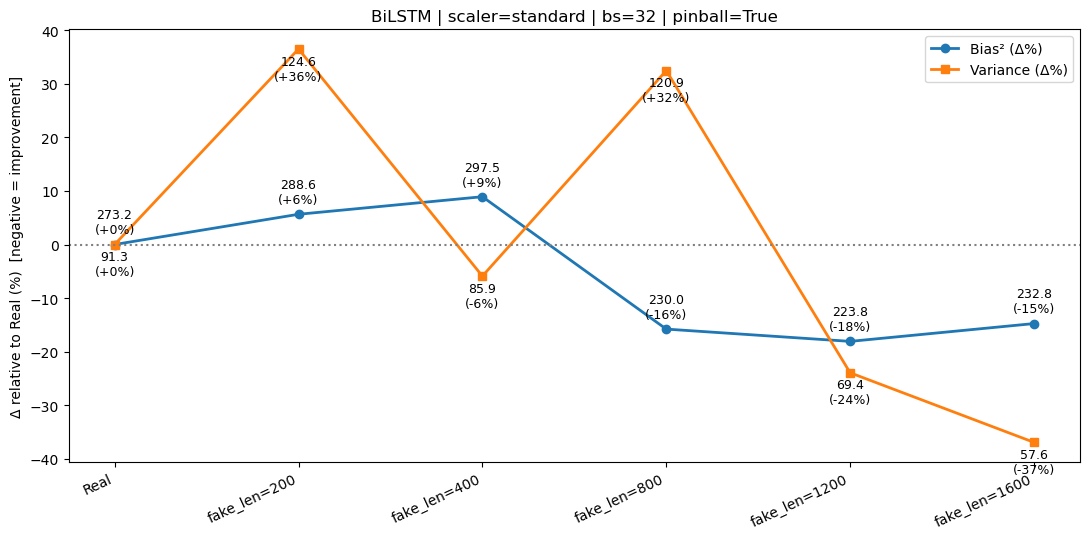

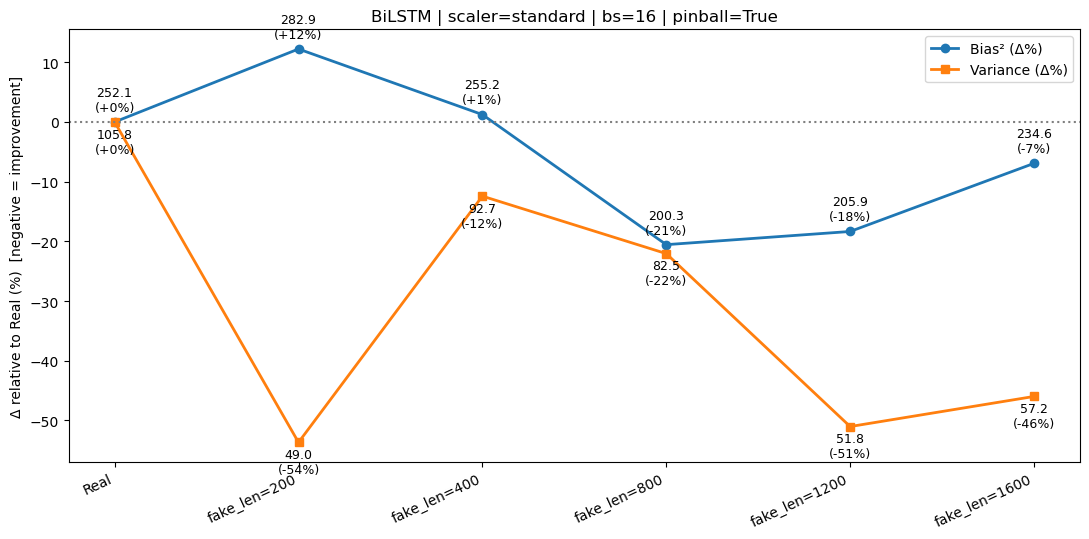

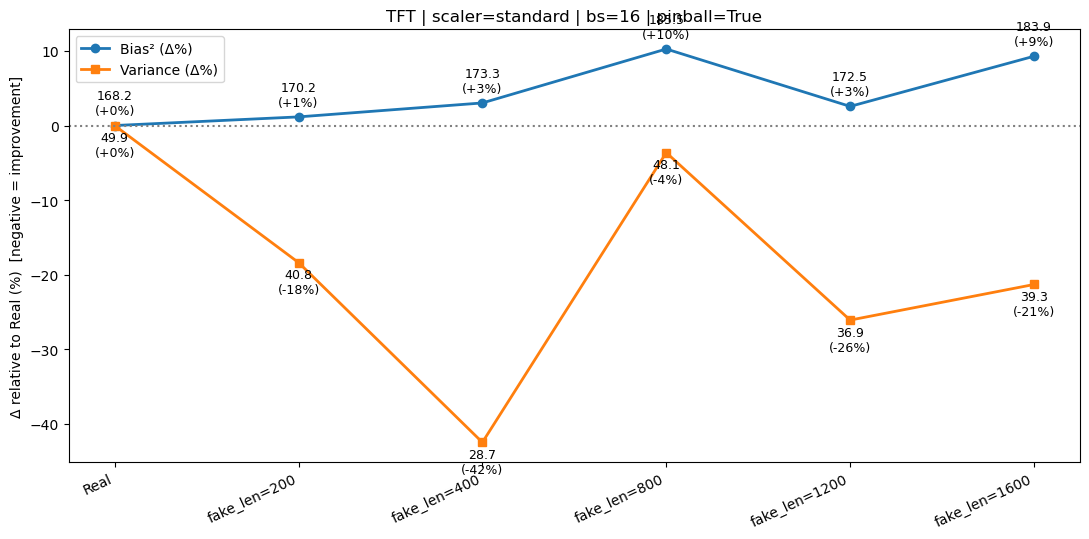

In [16]:
# --- stats, coverage, grouping, plotting (same as point) ---
def compute_stats_per_config(configs: dict) -> Dict[Tuple, dict]:
    return {k: bias_variance_from_seeds(v["y_true"], v["preds"]) for k, v in configs.items()}

stats = compute_stats_per_config(configs)
print(f"Computed stats for {len(stats)} configurations.")

def summarize_coverage(stats: dict):
    cov = defaultdict(lambda: {"has_real": False, "fake_lens": set()})
    for key in stats.keys():
        model, scaler, batch, data_aug, pinball, fake_len = key if len(key)==6 else (*key, None)
        base = (model, scaler, batch, pinball)
        if data_aug in (False, 0, "False", "false", None): cov[base]["has_real"] = True
        else: cov[base]["fake_lens"].add(fake_len)
    total = len(cov)
    paired = sum(1 for v in cov.values() if v["has_real"] and v["fake_lens"])
    only_real = sum(1 for v in cov.values() if v["has_real"] and not v["fake_lens"])
    only_aug  = sum(1 for v in cov.values() if (not v["has_real"]) and v["fake_lens"])
    print(f"Base configs: {total} | Paired: {paired} | Real-only: {only_real} | Aug-only: {only_aug}")
    return cov

coverage = summarize_coverage(stats)

def group_for_comparison(stats: dict):
    comps = defaultdict(lambda: {"real": None, "aug": {}})
    for key, s in stats.items():
        model, scaler, batch, data_aug, pinball, fake_len = key if len(key)==6 else (*key, None)
        base_key = (model, scaler, batch, pinball)
        if data_aug in (False, 0, "False", "false", None): comps[base_key]["real"] = s
        else: comps[base_key]["aug"][fake_len] = s
    return {k:v for k,v in comps.items() if v["real"] is not None and v["aug"]}

comps = group_for_comparison(stats)
print(f"Paired base configs ready: {len(comps)}")

def _sort_key_len(k):
    try: return (0, float(k))
    except: return (1, str(k))

def _label_for(k): return "Real" if k == "__REAL__" else f"fake_len={k}"

def plot_bias_var_percent(comps: dict, annotate: bool = True, round_vals: int = 1):
    for (model, scaler, batch, pinball), bundle in comps.items():
        real_stats = bundle["real"]; aug_map = bundle["aug"]
        keys = ["__REAL__"] + [k for k,_ in sorted(aug_map.items(), key=lambda kv: _sort_key_len(kv[0]))]
        labels = [_label_for(k) for k in keys]
        bias_abs, var_abs, mse_abs = [], [], []
        for k in keys:
            s = real_stats if k=="__REAL__" else aug_map[k]
            bias_abs.append(float(s["bias2"])); var_abs.append(float(s["var"])); mse_abs.append(float(s["mse"]))
        bias_abs, var_abs = np.array(bias_abs), np.array(var_abs)
        b0 = bias_abs[0] if bias_abs[0] != 0 else 1.0
        v0 = var_abs[0]  if var_abs[0]  != 0 else 1.0
        bias_pct = 100 * bias_abs / b0; var_pct  = 100 * var_abs  / v0

        x = np.arange(len(keys))
        plt.figure(figsize=(11, 5.5))
        plt.plot(x, bias_pct, marker="o", linewidth=2, label="Bias²")
        plt.plot(x, var_pct,  marker="s", linewidth=2, label="Variance")
        plt.xticks(x, labels, rotation=25, ha="right")
        plt.ylabel("Relative to Real (%)")
        plt.title(f"{model} | scaler={scaler} | bs={batch} | pinball={pinball} | q={USE_QUANTILE_VALUE}")
        plt.legend()
        if annotate:
            for xi, (bp, ba) in enumerate(zip(bias_pct, bias_abs)):
                plt.annotate(f"{ba:.{round_vals}f}\n({bp:.0f}%)", (xi, bp),
                             textcoords="offset points", xytext=(0, 8), ha="center", fontsize=9)
            for xi, (vp, va) in enumerate(zip(var_pct, var_abs)):
                plt.annotate(f"{va:.{round_vals}f}\n({vp:.0f}%)", (xi, vp),
                             textcoords="offset points", xytext=(0, -22), ha="center", fontsize=9)
        plt.tight_layout(); plt.show()



import numpy as np
import matplotlib.pyplot as plt

# ---------- plotting (percent vs REAL, annotated) ----------
def _sort_key_len(k):
    try: return (0, float(k))
    except: return (1, str(k))

def _label_for(k): return "Real" if k == "__REAL__" else f"fake_len={k}"

def plot_bias_var_delta(comps: dict, annotate: bool = True, round_vals: int = 1):
    """
    Plots Bias² and Variance as Δ% relative to the Real baseline (Real=0%).
    Negative Δ% means improvement (lower than Real).
    """
    for (model, scaler, batch, pinball), bundle in comps.items():
        real_stats = bundle["real"]; aug_map = bundle["aug"]
        keys = ["__REAL__"] + [k for k,_ in sorted(aug_map.items(), key=lambda kv: _sort_key_len(kv[0]))]
        labels = [_label_for(k) for k in keys]

        bias_abs, var_abs = [], []
        for k in keys:
            s = real_stats if k=="__REAL__" else aug_map[k]
            bias_abs.append(float(s["bias2"]))
            var_abs.append(float(s["var"]))
        bias_abs, var_abs = np.array(bias_abs), np.array(var_abs)

        # % vs REAL
        b0 = bias_abs[0] if bias_abs[0] != 0 else 1.0
        v0 = var_abs[0]  if var_abs[0]  != 0 else 1.0
        bias_pct = 100 * bias_abs / b0
        var_pct  = 100 * var_abs  / v0

        # Δ% (baseline at 0)
        bias_delta = bias_pct - 100.0
        var_delta  = var_pct  - 100.0

        x = np.arange(len(keys))
        plt.figure(figsize=(11, 5.5))
        plt.plot(x, bias_delta, marker="o", linewidth=2, label="Bias² (Δ%)")
        plt.plot(x, var_delta,  marker="s", linewidth=2, label="Variance (Δ%)")
        plt.xticks(x, labels, rotation=25, ha="right")
        plt.axhline(0, color="gray", linestyle=":")
        plt.ylabel("Δ relative to Real (%)  [negative = improvement]")
        title_pin = f" | pinball={pinball}" if pinball not in (False, 0, "False", "false", None) else ""
        plt.title(f"{model} | scaler={scaler} | bs={batch}{title_pin}")
        plt.legend()

        if annotate:
            # annotate with absolute + Δ%
            for xi, (d, a) in enumerate(zip(bias_delta, bias_abs)):
                plt.annotate(f"{a:.{round_vals}f}\n({d:+.0f}%)", (xi, d),
                             textcoords="offset points", xytext=(0, 8), ha="center", fontsize=9)
            for xi, (d, a) in enumerate(zip(var_delta, var_abs)):
                plt.annotate(f"{a:.{round_vals}f}\n({d:+.0f}%)", (xi, d),
                             textcoords="offset points", xytext=(0, -22), ha="center", fontsize=9)

        plt.tight_layout(); plt.show()


import os
import numpy as np
import pandas as pd

def _best_idx_lower_is_better(arr):
    arr = np.asarray(arr, dtype=float)
    return int(np.nanargmin(arr)) if arr.size else None

def build_biasvar_delta_table_for_group(real_stats, aug_map, fake_lens, decimals=1):
    """
    Returns a DataFrame with rows [Bias^2 (Δ%), Variance (Δ%)], columns:
      200, 400, 800, 1200, 1600 (Δ%) + Best (Δ%) + Best n + Real (abs)
    """
    # sort fake lens
    def _sort_key_len(k):
        try: return (0, float(k))
        except: return (1, str(k))
    fake_lens_sorted = sorted(fake_lens, key=_sort_key_len)

    # Absolute
    bias_abs = [float(real_stats["bias2"])]
    var_abs  = [float(real_stats["var"])]
    for L in fake_lens_sorted:
        s = aug_map[L]
        bias_abs.append(float(s["bias2"]))
        var_abs.append(float(s["var"]))

    # Relative % vs Real, then Δ%
    b0 = bias_abs[0] if bias_abs[0] != 0 else 1.0
    v0 = var_abs[0]  if var_abs[0]  != 0 else 1.0
    bias_delta = 100*np.array(bias_abs)/b0 - 100.0
    var_delta  = 100*np.array(var_abs)/v0  - 100.0

    cols = [str(L) for L in fake_lens_sorted]
    rows = []

    # Bias^2 row (lower is better → most negative Δ%)
    best_b_idx = _best_idx_lower_is_better(bias_delta[1:])
    bias_row = {"Metric": "Bias$^2$ (Δ\%)"}
    for i, c in enumerate(cols):
        val = bias_delta[i+1]
        cell = f"{val:.{decimals}f}\\%"
        if best_b_idx is not None and i == best_b_idx:
            cell = f"\\textbf{{{cell}}}"
        bias_row[c] = cell
    bias_row["Best (Δ\%)"] = f"\\textbf{{{bias_delta[1+best_b_idx]:.{decimals}f}\\%}}" if best_b_idx is not None else ""
    bias_row["Best n"]     = f"\\textbf{{{fake_lens_sorted[best_b_idx]}}}"       if best_b_idx is not None else ""
    bias_row["Real (abs)"] = f"{bias_abs[0]:.{decimals}f}"
    rows.append(bias_row)

    # Variance row
    best_v_idx = _best_idx_lower_is_better(var_delta[1:])
    var_row = {"Metric": "Variance (Δ\%)"}
    for i, c in enumerate(cols):
        val = var_delta[i+1]
        cell = f"{val:.{decimals}f}\\%"
        if best_v_idx is not None and i == best_v_idx:
            cell = f"\\textbf{{{cell}}}"
        var_row[c] = cell
    var_row["Best (Δ\%)"] = f"\\textbf{{{var_delta[1+best_v_idx]:.{decimals}f}\\%}}" if best_v_idx is not None else ""
    var_row["Best n"]     = f"\\textbf{{{fake_lens_sorted[best_v_idx]}}}"          if best_v_idx is not None else ""
    var_row["Real (abs)"] = f"{var_abs[0]:.{decimals}f}"
    rows.append(var_row)

    df_tbl = pd.DataFrame(rows)
    return df_tbl[["Metric"] + cols + ["Best (Δ\%)", "Best n", "Real (abs)"]]

def export_biasvar_delta_tables(
    comps,
    save_dir="latex_tables_biasvar",
    two_column=True,
    decimals=1,
    caption_tpl="Bias–variance Δ\% (relative to Real) across synthetic lengths for {model} | {scaler} | bs={bs}{pinball_suffix}. "
                "Negative is improvement. Best entries per row are in bold.",
    label_tpl="tab:bvdelta_{model}_{scaler}_bs{bs}{pinball_tag}",
    also_write_combined=True,
    combined_caption="Bias–variance Δ\% across all model/scaler/batch configurations. Negative = improvement.",
    combined_label="tab:bvdelta_all"
):
    os.makedirs(save_dir, exist_ok=True)
    combined_frames = []

    for (model, scaler, batch, pinball), bundle in comps.items():
        real_stats = bundle["real"]; aug_map = bundle["aug"]
        if not aug_map: 
            continue
        fake_lens = list(aug_map.keys())
        df_tbl = build_biasvar_delta_table_for_group(real_stats, aug_map, fake_lens, decimals=decimals)

        # keep a version with id columns for combined table
        df_id = df_tbl.copy()
        df_id.insert(0, "Model", model)
        df_id.insert(1, "Scaler", scaler)
        df_id.insert(2, "Batch", batch)
        combined_frames.append(df_id)

        # per-config TeX
        tabular = df_tbl.to_latex(index=False, escape=False, column_format="l" + "r"*(df_tbl.shape[1]-1), na_rep="")
        pinball_suffix = "" if (pinball in (False, 0, "False", "false", None)) else f" | pinball={pinball}"
        pinball_tag    = "" if (pinball in (False, 0, "False", "false", None)) else f"_pinball{pinball}"

        tex = (
            "\\renewcommand{\\arraystretch}{1.2}\n"
            f"\\begin{{{ 'table*' if two_column else 'table' }}}[!t]\n"
            "\\centering\n\\footnotesize\n"
            f"\\caption{{{caption_tpl.format(model=model, scaler=scaler, bs=batch, pinball_suffix=pinball_suffix)}}}\n"
            f"\\label{{{label_tpl.format(model=str(model).replace(' ',''), scaler=str(scaler).replace(' ',''), bs=batch, pinball_tag=pinball_tag)}}}\n"
            "\\setlength{\\tabcolsep}{5pt}\n"
            f"{tabular}\n"
            f"\\end{{{ 'table*' if two_column else 'table' }}}\n"
        )
        out = os.path.join(save_dir, f"bv_delta_{model}_{scaler}_bs{batch}{pinball_tag}.tex").replace(" ", "")
        with open(out, "w", encoding="utf-8") as f:
            f.write(tex)

    # Combined table
    if also_write_combined and combined_frames:
        big = pd.concat(combined_frames, ignore_index=True)
        # order columns nicely
        cols = list(big.columns)
        # ensure "Best (Δ%)", "Best n", "Real (abs)" are last and in that order
        tail = ["Best (Δ\\%)", "Best n", "Real (abs)"]
        head = [c for c in cols if c not in tail]
        big = big[head + tail]

        tabular = big.to_latex(index=False, escape=False,
                               column_format="l l l l " + "r"*(big.shape[1]-4), na_rep="")

        combined_tex = (
            "\\renewcommand{\\arraystretch}{1.2}\n"
            f"\\begin{{{ 'table*' if two_column else 'table' }}}[!t]\n"
            "\\centering\n\\footnotesize\n"
            f"\\caption{{{combined_caption}}}\n"
            f"\\label{{{combined_label}}}\n"
            "\\setlength{\\tabcolsep}{4pt}\n"
            f"{tabular}\n"
            f"\\end{{{ 'table*' if two_column else 'table' }}}\n"
        )
        with open(os.path.join(save_dir, "bv_delta_all_pinball.tex"), "w", encoding="utf-8") as f:
            f.write(combined_tex)

            
# Plots in Δ%
plot_bias_var_delta(comps, annotate=True)

# Tables in Δ% + combined file
export_biasvar_delta_tables(
    comps,
    save_dir="latex_tables_biasvar_delta",
    two_column=True,
    decimals=1,
    also_write_combined=True
)


